In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from skimage import draw
import pandas as pd
from torchsummary import summary
from scipy import ndimage 
import sys

# Creating Dataset

## Helper Functions

In [5]:
# Directories
# csv_dir = "../../DATASET/csv"
csv_dir = '/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/SRater_corrected/csv'

# im_dir = "../../DATASET/rgb"
im_dir = "/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/SRater_corrected/rgb"

# Get File Names
def get_files(dir):
    return [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

# Get CSV Dataframes 
def get_csv_df(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return pd.read_csv(path)

# Get Image Data
def get_im_data(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return plt.imread(path)

def crop_img(image, xmin, ymin, xmax, ymax):
    return image[ymin:ymax, xmin:xmax]

def get_xy(csv_df,idx):
    return csv_df[['coords_x', 'xmin', 'xmax', 'ymin', 'ymax', 'coords_y']].iloc[idx].to_dict()

def cell_mask(img, x_cord, y_cord):
    if len(x_cord) != len(y_cord):
        raise ValueError("Length of x_cord and y_cord must be equal")
    
def get_nuc(img, csv, xshape, yshape, x_window = [70,100], y_window = [70,100]):
    num_nuc = len(csv)
    nucs_list = []
    for i in range(num_nuc):
        nuc = get_xy(csv, i)

        x_range =  nuc['xmax'] - nuc['xmin']
        y_range = nuc['ymax'] - nuc['ymin']
        if (x_range < x_window[0] or x_range > x_window[1]) and (y_range < y_window[0] or y_range > y_window[1]):
            continue
        x =  np.array(nuc['coords_x'].split(",")).astype(int) 
        y =  np.array(nuc['coords_y'].split(",")).astype(int)
        im_h, im_w, im_c = img.shape
        mask = np.zeros((im_h, im_w, im_c), dtype=np.uint8)
        rr, cc = draw.polygon(y, x)
        try:
            mask[rr, cc,:] = 1
        except IndexError:
            continue
        del_back = np.multiply(mask, img)
        cropped_nuc = crop_img(del_back, nuc['xmin'], nuc['ymin'], nuc['xmax'], nuc['ymax'])
        blank_mask = np.zeros((xshape, yshape, 3))
        center_height = (blank_mask.shape[0] - cropped_nuc.shape[0]) // 2
        center_width = (blank_mask.shape[1] - cropped_nuc.shape[1]) // 2
        try:
            blank_mask[center_height:center_height + cropped_nuc.shape[0], center_width:center_width + cropped_nuc.shape[1], :] = cropped_nuc
        except:
            continue
        nucs_list.append(blank_mask)
    return nucs_list


## Get image

(364, 360, 3)


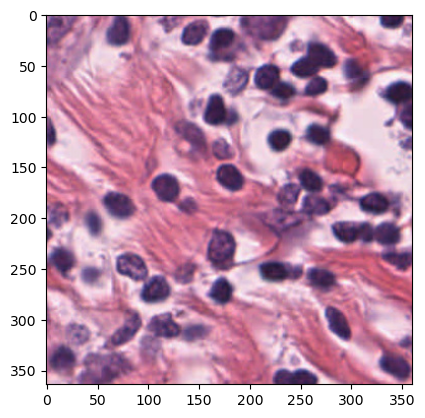

In [6]:
csv_files = get_files(csv_dir)
im_files = get_files(im_dir)
im_files = get_files(im_dir)
img_array = get_im_data(im_dir, im_files, 0)
print(img_array.shape)
plt.imshow(img_array)
plt.show()

## Boundary Regions from CSV files

In [4]:
csv_df = get_csv_df(csv_dir, csv_files, 0)
csv_df

,Unnamed: 0,raw_classification,main_classification,super_classification,type,xmin,ymin,xmax,ymax,coords_x,coords_y
0,0,tumor,tumor_nonMitotic,tumor_any,polyline,204,144,262,192,"204,204,205,214,224,233,239,255,260,262,262,25...","186,156,151,145,144,145,146,151,156,161,164,17..."
1,1,tumor,tumor_nonMitotic,tumor_any,polyline,270,158,316,186,"271,270,272,275,279,293,300,305,310,316,316,31...","177,172,167,164,161,158,158,159,161,167,175,18..."
2,2,tumor,tumor_nonMitotic,tumor_any,polyline,4,260,47,322,"4,8,18,37,42,45,47,44,42,38,35,32,26,16,11,8,4,4","290,270,260,260,262,274,280,305,310,315,318,32..."
3,3,tumor,tumor_nonMitotic,tumor_any,polyline,106,282,152,327,"152,152,146,127,121,119,106,107,115,133,141,14...","291,327,327,325,324,322,315,309,282,282,283,28..."
4,4,tumor,tumor_nonMitotic,tumor_any,polyline,97,241,128,262,"97,102,107,115,126,128,126,124,120,114,107,105...","247,242,241,242,244,248,257,259,260,262,260,25..."
5,5,tumor,tumor_nonMitotic,tumor_any,polyline,64,17,96,58,"66,64,65,70,83,88,93,95,96,96,95,84,80,74,71,6...","48,39,35,27,20,17,19,20,29,35,39,55,58,58,57,5..."
6,6,tumor,tumor_nonMitotic,tumor_any,rectangle,140,175,202,225,"140,202,202,140,140","175,175,225,225,175"
7,7,tumor,tumor_nonMitotic,tumor_any,rectangle,280,206,334,263,"280,334,334,280,280","206,206,263,263,206"
8,8,tumor,tumor_nonMitotic,tumor_any,rectangle,293,58,345,115,"293,345,345,293,293","58,58,115,115,58"
9,9,tumor,tumor_nonMitotic,tumor_any,rectangle,18,195,53,262,"18,53,53,18,18","195,195,262,262,195"


## Match Files with Corresponding Images

In [5]:
matching_files = []
for csv in csv_files:
    for im in im_files:
        csv_d = os.path.splitext(csv)[0]
        im_d = os.path.splitext(im)[0]
        if csv_d == im_d:
            matching_files.append((csv,im))
        # if csv.startswith("SP") and im.startswith("SP"):
        #     csv_d = os.path.splitext(csv)[0]
        #     im_d = os.path.splitext(im)[0]
        #     if csv_d == im_d:
        #         matching_files.append((csv,im))
print("Number of matching files =", len(matching_files))
matching_files[0]

Number of matching files = 1744


('TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589.csv',
 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589.png')

## Create Pickle Array

In [72]:
# csv_dir = "../../DATASET/csv"
# im_dir = "../../DATASET/rgb"
csv_dir = '/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/SRater_corrected/csv'
im_dir = "/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/SRater_corrected/rgb"

csv_files = get_files(csv_dir)
im_files = get_files(im_dir)
im_save_dir = "../../DATASET/nuc"
class_map = {'raw_classification':0, "main_classification":1, 'super_classification':2}
org_class = class_map['super_classification']
pickle_array = []

final_df = pd.DataFrame(columns=["file_name", 'raw_classification', "main_classification",'super_classification'])
iters = 0
stop = 100
for i, files in enumerate(matching_files):
    csv_path = os.path.join(csv_dir, files[0])
    csv_df = pd.read_csv(csv_path)
    
    im_path = os.path.join(im_dir, files[1])
    img = plt.imread(im_path)
    
    try: 
        nucs = get_nuc(img, csv_df, xshape = 80, yshape = 80, x_window = [25,75], y_window = [25,75])
    except IndexError:
        print(files)
        continue
        
    for j, nuc in enumerate(nucs):
        label_df = csv_df[['raw_classification', "main_classification", 'super_classification']].iloc[j]
        label = label_df.to_numpy()
        
        if 'unlabeled' not in label and 'AMBIGUOUS' not in label and np.mean(nuc) > 0 and "other_nucleus" not in label:
            # im_name = f"im_{iters}.png"
            pickle_lst = [nuc.transpose(2,0,1), label]
            pickle_array.append(pickle_lst)
            # for k in range(4):
            #     rotated_nuc = ndimage.rotate(nuc, k*90)
            #     pickle_lst = [rotated_nuc.transpose(2,0,1), label]
            #     pickle_array.append(pickle_lst)

len(pickle_array)

42750

## Create Dataset

In [73]:
pickle_path = os.path.join(im_save_dir, 'single_rater.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(pickle_array, f)

In [74]:
del pickle_array

## Pickle Loader

In [8]:
def load_dataset(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data 
im_save_dir = "/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/nuc"
# pickle_path = os.path.join(im_save_dir, 'nuc_data.pkl')
# pikl_sp_path = os.path.join(im_save_dir, 'nuc_sp_data.pkl')
# nuc_sp_Nothernuc_path = os.path.join(im_save_dir, 'nuc_sp_Nothernuc.pkl')
single_rater = os.path.join(im_save_dir, 'single_rater.pkl')
# data = load_dataset(pickle_path)
data = load_dataset(single_rater)

# Show Images and Labels 

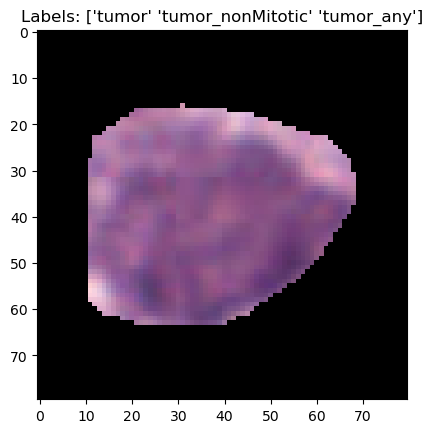

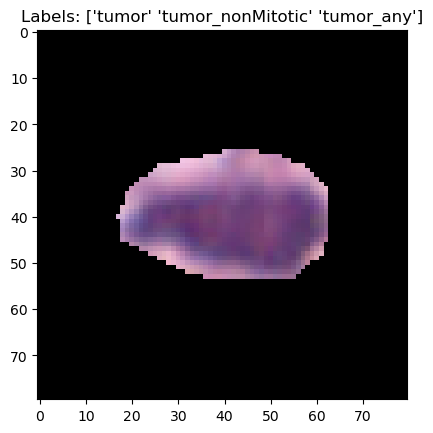

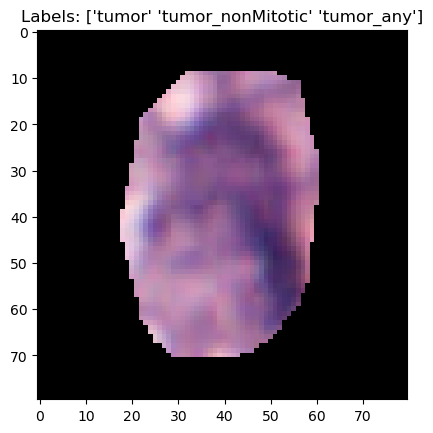

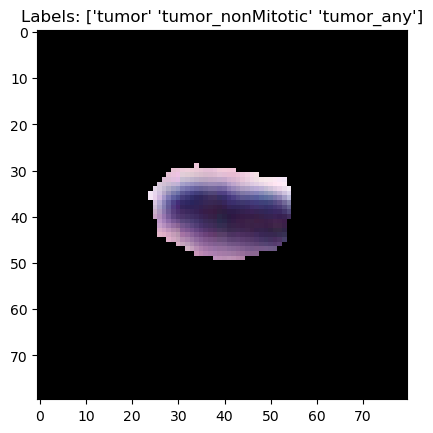

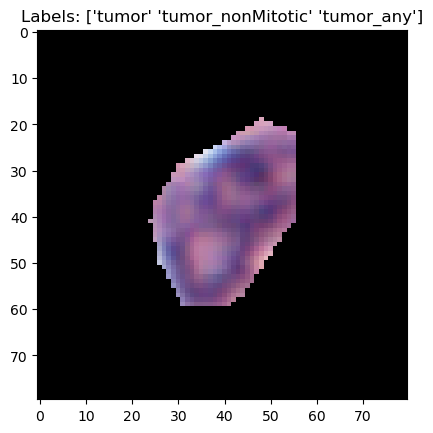

In [18]:
for i in range(5):
    plt.title(f"Labels: {data[i][1]}")
    plt.imshow(data[i][0].transpose(1,2,0))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 3, figsize=(10, 30))  # Create a 10x3 grid of subplots

for i, ax in enumerate(axs.flatten()):  # Flatten the 2D array of axes into 1D for easy iteration
    ax.set_title(f"Labels: {data[i][1][3]}")
    ax.imshow(data[i][0].transpose(1,2,0))
    ax.axis('off')  # Optional: remove the axis

plt.tight_layout()  # Optional: improve spacing between subplots
plt.show()

# Dataset Class

In [11]:
class NuCLSDataset(Dataset):
    def __init__(self, X, y, mode='CNN', bkgd='black'):
        super().__init__()
        self.bkgd = bkgd
        padded_X = X
        if self.bkgd == 'black':
            self.X = padded_X # just pad the input X's with black to the right dimension
            # print(f'Shape of padded X: {self.X.shape}')
        else: # change black pixels to average value fo pixels in the cropped image
            for i in range(padded_X.shape[0]):
                im = padded_X[i].transpose(1,2,0)
                non_black_pixels = im[im.sum(axis=2) > 0]
                average_color = np.mean(non_black_pixels, axis=0)
                mask = np.all(im == [0, 0, 0], axis=-1)
                im[mask] = average_color.astype(float)
                padded_X[i] = im.transpose(2,0,1)
            self.X = padded_X

        self.X = torch.tensor(self.X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.mode = mode
        
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        if self.mode == 'CNN':
            return self.X[idx], self.y[idx] # CNN returns index, for logreg returns flttened image
        else:
            return self.X[idx].reshape(-1), self.y[idx]

# Basic CNN network

In [3]:
class Cell_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # conv  
        self.conv1 = nn.Conv2d(3,10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5, stride = 2)
        self.conv3 = nn.Conv2d(20,30, kernel_size=5, stride = 2)

        # pool 
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)

        # activation function
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

        # dropout layer
        self.dropout = nn.Dropout(0.5)

        # batch normalization
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(30)

        # flatten
        self.flatten = nn.Flatten()

        # fully connected layer
        fcconst = 30 * 3 * 3
        self.fc1 = nn.Linear(fcconst, fcconst)
        self.fc2 = nn.Linear(fcconst, num_classes)

    def forward(self, x):
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x   

model = Cell_CNN()
s = summary(model, (3, 80, 80))
# p = '/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/results/summary.txt'
# # Save the original standard output
# original_stdout = sys.stdout 
# with open(p, 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     ds = summary(model, (3, 80, 80))
#     sys.stdout = original_stdout # Reset the standard output to its original value

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 38, 38]          760
├─BatchNorm2d: 1-2                       [-1, 10, 38, 38]          20
├─ReLU: 1-3                              [-1, 10, 38, 38]          --
├─MaxPool2d: 1-4                         [-1, 10, 36, 36]          --
├─Conv2d: 1-5                            [-1, 20, 16, 16]          5,020
├─BatchNorm2d: 1-6                       [-1, 20, 16, 16]          40
├─ReLU: 1-7                              [-1, 20, 16, 16]          --
├─MaxPool2d: 1-8                         [-1, 20, 14, 14]          --
├─Conv2d: 1-9                            [-1, 30, 5, 5]            15,030
├─BatchNorm2d: 1-10                      [-1, 30, 5, 5]            60
├─ReLU: 1-11                             [-1, 30, 5, 5]            --
├─MaxPool2d: 1-12                        [-1, 30, 3, 3]            --
├─Flatten: 1-13                          [-1, 270]                 --
├─Linea

# First Results from Training a Basic CNN structure
![](/Users/keelanoriordan/Desktop/GitHub_MacStu.nosync/242-Final-Project/Submission/April_9/lossacc.jpeg)


# Densenet

In [81]:
from torchvision import models
class DenseNet_pytorch(nn.Module):
    def __init__(self, num_classes=4):
        super(DenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=False)

        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):   
        x = self.densenet(x)
        return x

# densenet = DenseNet()
# ds = summary(densenet, (3, 80, 80), verbose=2)
# p = '/Users/keelanoriordan/Desktop/GitHub_MacPro.nosync/242-Final-Project/DATASET/results/summary.txt'
# # Save the original standard output
# original_stdout = sys.stdout 
# with open(p, 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     ds = summary(densenet, (3, 80, 80))
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers, drop_rate=0.4, b_con = True):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([self._make_layer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])
        self.dropout = nn.Dropout2d(drop_rate)
        self.b_con = b_con

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            nn.BatchNorm2d(growth_rate),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        for layer in self.layers:
            if self.b_con:
                temp = x
            x = layer(x)
            x = self.dropout(x)
            if self.b_con:
                x = torch.cat([x, temp], 1)
        return x

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=3, num_classes=3, drop_rate=0.4):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        in_channels = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(in_channels, growth_rate, num_layers, drop_rate)
            self.features.add_module(f'denseblock{i + 1}', block)
            in_channels = in_channels + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionBlock(in_channels, in_channels // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                in_channels = in_channels // 2

        self.features.add_module('norm5', nn.BatchNorm2d(in_channels))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('avgpool5', nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

densenet = DenseNet(growth_rate=64, block_config=(8, 10, 12, 14), num_init_features=64, num_classes=3, drop_rate=0.4)
ds = summary(densenet, (3, 80, 80), verbose=1)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1512, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 40, 40]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 40, 40]          128
|    └─ReLU: 2-3                         [-1, 64, 40, 40]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 20, 20]          --
|    └─DenseBlock: 2-5                   [-1, 576, 20, 20]         --
|    |    └─Dropout2d: 3-1               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-2               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-3               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-4               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-5               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-6               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-7               [-1, 64, 20, 20]          --
|    |    └

In [3]:
class DenseNet_2block(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12), num_init_features=3, num_classes=3, drop_rate=0.4):
        super(DenseNet_2block, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        in_channels = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(in_channels, growth_rate, num_layers, drop_rate)
            self.features.add_module(f'denseblock{i + 1}', block)
            in_channels = in_channels + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionBlock(in_channels, in_channels // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                in_channels = in_channels // 2

        self.features.add_module('norm5', nn.BatchNorm2d(in_channels))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('avgpool5', nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

densenet_2 = DenseNet_2block(growth_rate=64, block_config=(8, 10), num_init_features=64, num_classes=3, drop_rate=0.4)
ds = summary(densenet_2, (3, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 928, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 40, 40]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 40, 40]          128
|    └─ReLU: 2-3                         [-1, 64, 40, 40]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 20, 20]          --
|    └─DenseBlock: 2-5                   [-1, 576, 20, 20]         --
|    |    └─Dropout2d: 3-1               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-2               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-3               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-4               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-5               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-6               [-1, 64, 20, 20]          --
|    |    └─Dropout2d: 3-7               [-1, 64, 20, 20]          --
|    |    └

# First Results form PyTorch Default Class of DenseNet before our implementation
![](/Users/keelanoriordan/Desktop/GitHub_MacStu.nosync/242-Final-Project/Submission/April_9/densenet_supclass.jpeg)

# Trainer Class

In [82]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu")
        self.model = model.to(self.device)
        
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        # for n in tqdm(range(self.epoch), leave=False):
        for n in range(self.epoch):
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == torch.argmax(y_batch, axis=-1)) / y_batch.shape[0]
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print(f"Epoch: {n+1}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}")
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == torch.argmax(y_batch, axis=-1)) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc

# Load Dataset

In [31]:
from sklearn.model_selection import train_test_split
from collections import Counter
class_map = {'raw_classification':0, "main_classification":1, 'super_classification':2}
data = [item for item in data if item[1][class_map['super_classification']] in ['sTIL', 'tumor_any']]
# X = np.array([data[i][0] for i in range(len(data))])
# y = np.array([data[i][1][class_map['super_classification']] for i in range(len(data))])

X = np.array([data[i][0] for i in range(len(data))])
y = np.array([data[i][1][class_map['super_classification']] for i in range(len(data))])
# y = np.array(["tumor" if data[i][1][class_map['super_classification']] == "tumor_any" else "healthy" for i in range(len(data))])
encoder = OneHotEncoder()
y_enc = encoder.fit_transform(y.reshape(-1,1)).toarray()
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, shuffle=True)
print("X =",X.shape, "y =", y.shape)
print("X_train =", X_train_c.shape, "y_train =", y_train_c.shape)
print("X_test =", X_test_c.shape, "y_test =", y_test_c.shape)
# print(y_enc.shape)
# print(type(y))
class_counts = Counter(y_train_c)
for class_label, count in class_counts.items():
    print(f"Train Class {class_label}: {count} items")

class_counts = Counter(y_test_c)
for class_label, count in class_counts.items():
    print(f"Test Class {class_label}: {count} items")

# train_data = NuCLSDataset(X=X_train, y=y_train, mode='CNN', bkgd='avg')
# test_data = NuCLSDataset(X=X_test, y=y_test, mode='CNN', bkgd='avg')

X = (42750, 3, 80, 80) y = (42750,)
X_train = (34200, 3, 80, 80) y_train = (34200,)
X_test = (8550, 3, 80, 80) y_test = (8550,)
Train Class sTIL: 11696 items
Train Class tumor_any: 15532 items
Train Class nonTIL_stromal: 6972 items
Test Class nonTIL_stromal: 1836 items
Test Class tumor_any: 3909 items
Test Class sTIL: 2805 items


In [72]:
lt = encoder.categories_
coded=encoder.transform(np.array(lt).reshape(-1,1)).toarray()
str(coded[0])
# coded_map = {lt[0][i]:str(coded[i]) for i in range(coded.shape[0])}
# coded_map.values()

'[1. 0. 0.]'

In [53]:
test = torch.tensor([True,True,False])
test.to('mps')
test.tolist()

[True, True, False]

In [58]:
from collections import defaultdict
res = defaultdict(int)
res[str([1,0,0])]+=1
res[str([0,1,0])]=0
res[str([0,0,1])]=3
res

defaultdict(int, {'[1, 0, 0]': 1, '[0, 1, 0]': 0, '[0, 0, 1]': 3})

In [18]:
19441+14501

33942

['nonTIL_stromal' 'sTIL' 'tumor_any']
Class tumor_any: 19441 items
Class nonTIL_stromal: 8808 items
Class sTIL: 14501 items


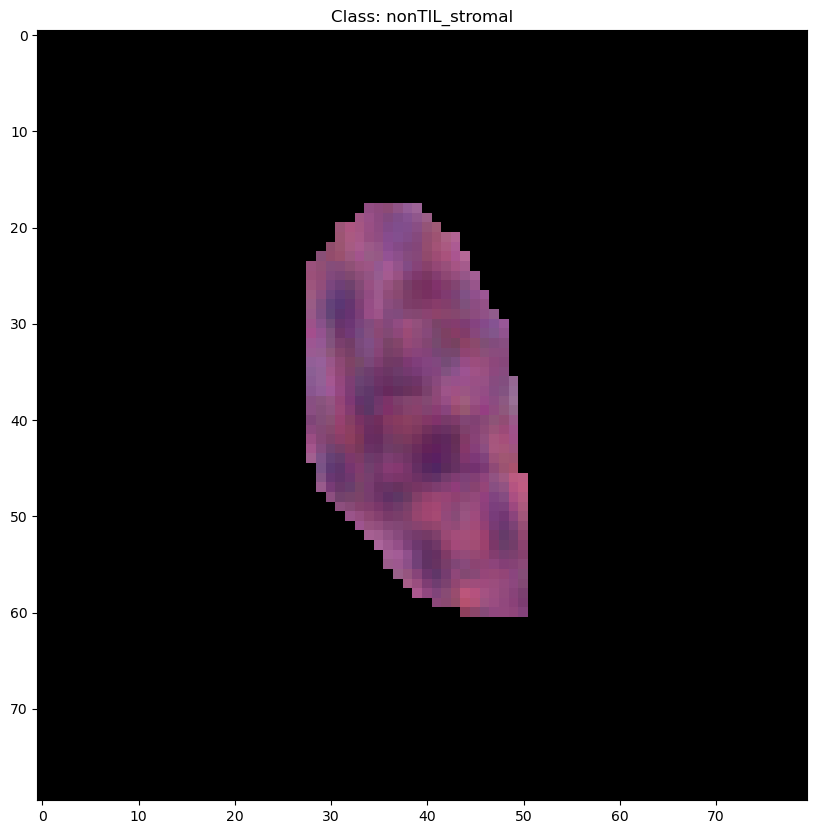

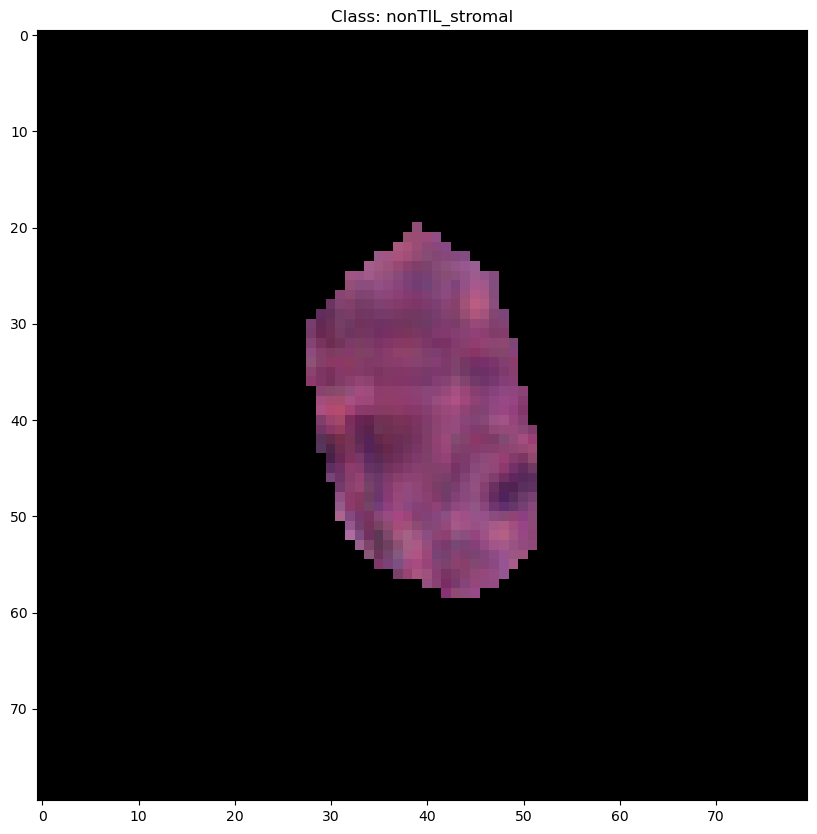

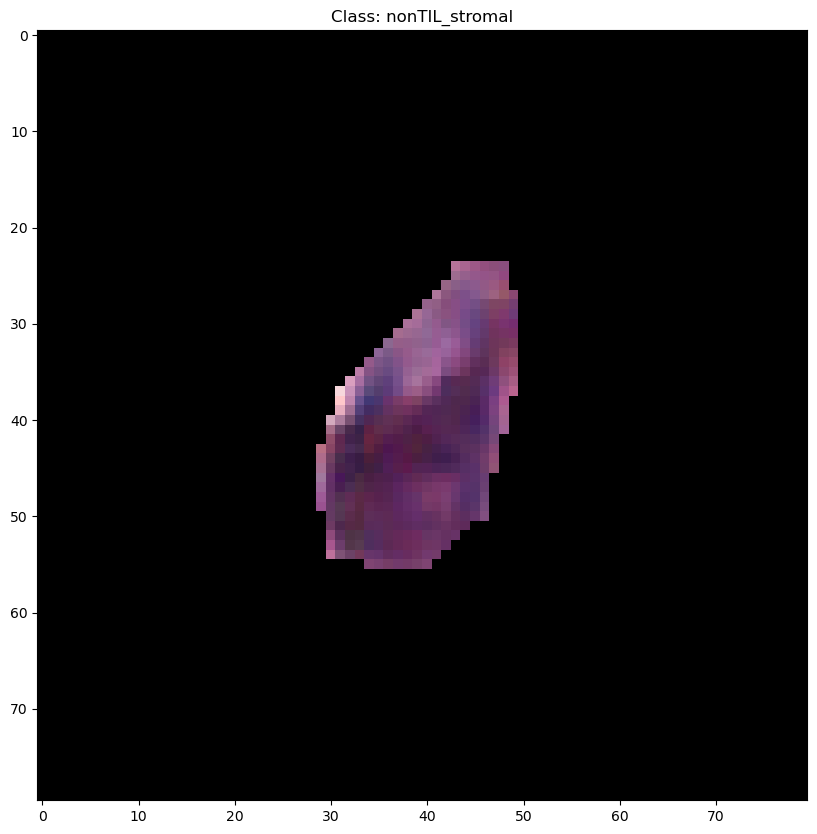

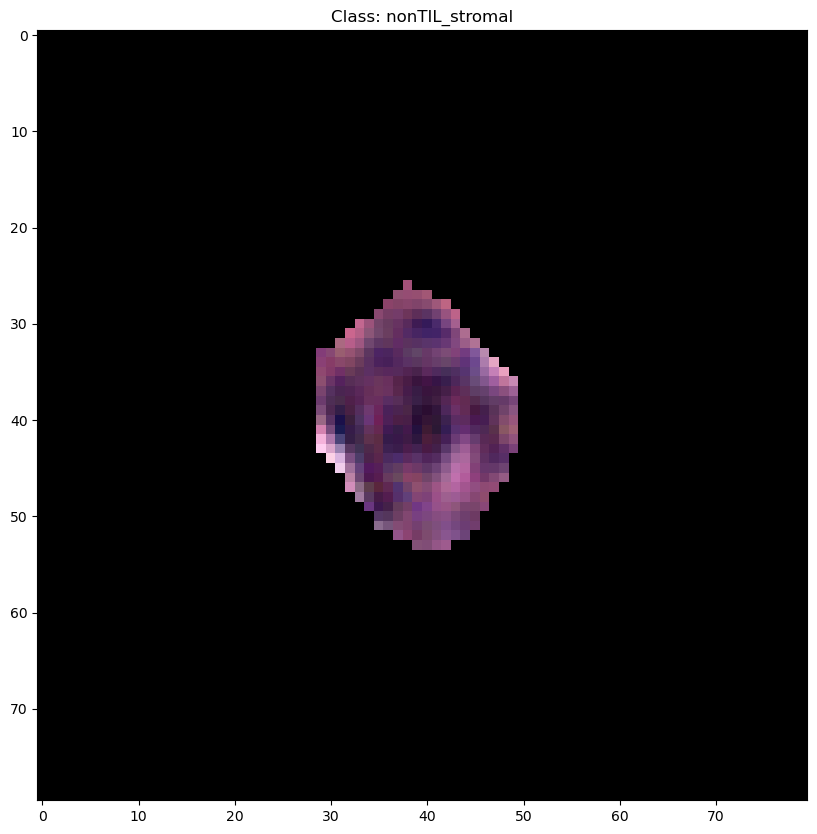

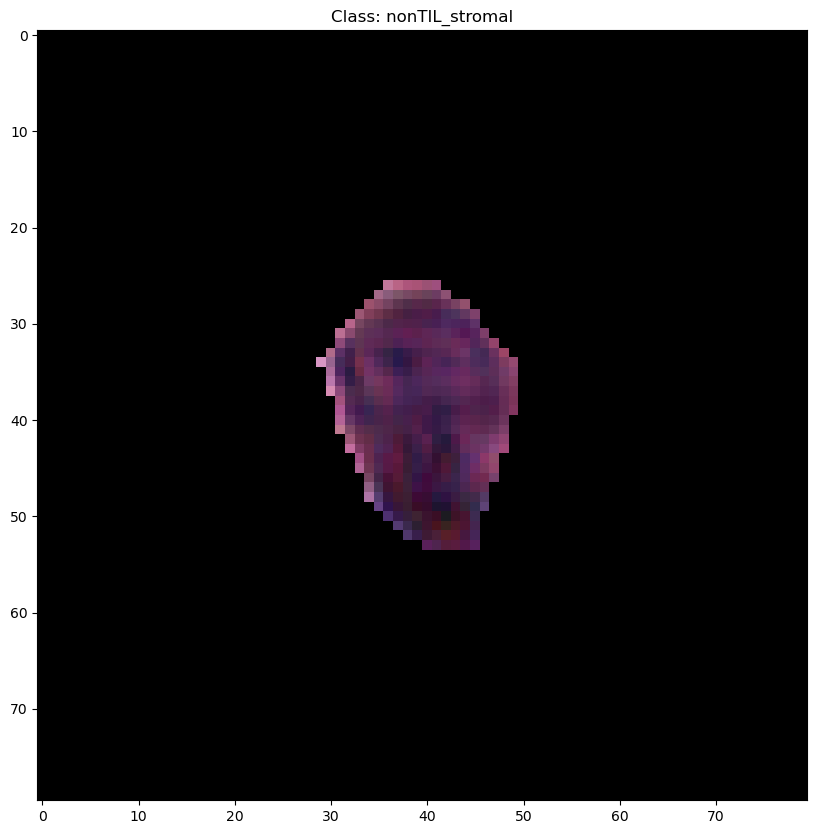

In [26]:
from collections import Counter
classes = np.unique(y)
idxtosupmap = {0:'nonTIL_stromal', 1:'sTIL',2:'tumor_any'}

print(classes)
specified_class = idxtosupmap[0] # Replace with your specified class

# Assuming y is your list of class labels
class_counts = Counter(y)

for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} items")

# Filter the data for the specified class
idx = 1
for idx in range(5):
    filtered_data = [item for item in data if 'nonTIL_stromal' in item[1]]
    plt.figure(figsize=(10, 10))
    plt.title(f"Class: {filtered_data[idx][1][2]}")
    plt.imshow(filtered_data[idx][0].transpose(1,2,0))
    plt.show()
# fig, axs = plt.subplots(10, 3, figsize=(10, 30))  # Create a 10x3 grid of subplots

# for i, ax in enumerate(axs.flatten()):  # Flatten the 2D array of axes into 1D for easy iteration
#     if i < len(filtered_data):  # Check if there is data to plot
#         ax.set_title(f"Class: {filtered_data[i][1][2]}")
#         ax.imshow(filtered_data[i][0].transpose(1,2,0))
#     ax.axis('off')  # Optional: remove the axis

# plt.tight_layout()  # Optional: improve spacing between subplots
# plt.show()

# Train Networks

In [67]:
dense_raw = DenseNet(num_classes=3)
basic_cnn = Cell_CNN(num_classes=3)
#param = [model, opt_method, learning_rate, batch_size, epoch, l2]
param = [dense_raw, "adam", 1e-4, 128, 100, 1e-5]
trainer = Trainer(param[0], param[1], param[2], param[3], param[4], param[5])
# trainer.train(train_data, test_data)
# print(dense_raw.parameters)

/Users/keelanoriordan/anaconda3/envs/chemc242/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/keelanoriordan/anaconda3/envs/chemc242/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# PCA and K Means Clustering

In [ ]:
# X = np.array([data[i][0] for i in range(len(data))])
# y = np.array([data[i][1][2] for i in range(len(data))])
# print(X)
# print(y)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X.reshape(-1, 80*80*3))
# print(X_pca)

## PCA True Labels

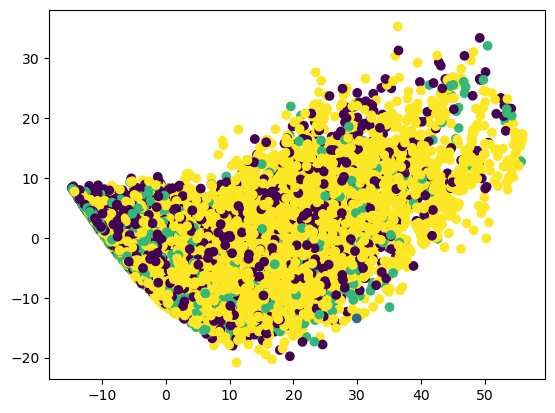

In [ ]:
# pc1 = X_pca[:,0]
# pc2 = X_pca[:,1]
# y_encoded = encoder.fit_transform(y.reshape(-1,1)).toarray()
# y_labels = np.argmax(y_encoded, axis=-1)
# plt.scatter(pc1, pc2, c=y_labels)
# plt.show()

In [ ]:
# from sklearn.cluster import KMeans
# num_clusters = 4

# kmeans = KMeans(n_clusters=num_clusters)
# kmeans.fit(X_pca)

# labels = kmeans.labels_

In [ ]:
# y_train_true_labs = y

# sclass2idx = {'nonTIL_stromal': 0, 'other_nucleus': 1, 'sTIL': 2, 'tumor_any': 3}
# y_train_labs_list = y_train_true_labs.squeeze().tolist()
# y_train_num = [sclass2idx[y_val] for y_val in y_train_labs_list]

# acc = (sum(labels==y_train_num))/len(labels) 
# print(acc)

0.3680412371134021


## K-Means Clustered

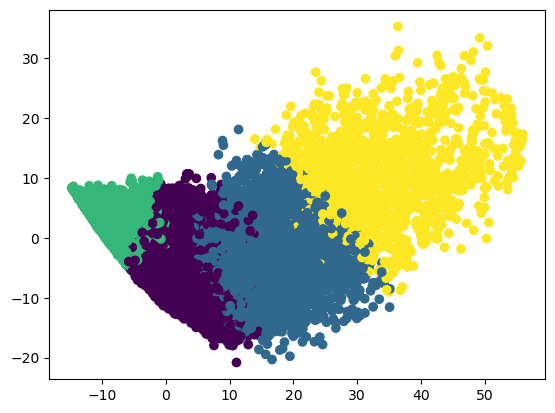

In [ ]:
# plt.scatter(pc1, pc2, c=labels)